In [1]:
#Bibliotecas
import json
import gzip
import pandas as pd
#import pandas_profiling

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.request import urlopen

In [2]:
# Cargar los datos

data = []
with gzip.open('Digital_Music.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

#Normalizar las columnas para separar style.Format:
data2 = pd.json_normalize(data)

#Convertir la lista a un dataframe de pandas
df = pd.DataFrame.from_dict(data2)

#Cantidad de datos en el dataframe
print(len(df))

1584082


In [3]:
###TRANSFORMACIONES
#Se eliminan las columnas que no se utilizaran
df = df.drop(['asin', 'unixReviewTime', 'image', 'reviewerName', 'style.Color:', 'style.Size:'], axis=1)

#Se crea la nueva columna en donde se categoriza el sentimiento postivo (1) y negativo (0)
df['sentiment'] = np.where(df['overall']>3, '1', '0')

#Cambiar el formato del reviewTime para transformarla a datetime
df['reviewTime'] = df['reviewTime'].str.replace(' ', ',')
df['reviewTime'] = df['reviewTime'].str.replace(',,', ',')
df['reviewTime'] = df['reviewTime'].str.replace(',', '-')
df['reviewTime'] = pd.to_datetime(df['reviewTime'], infer_datetime_format=True)

In [4]:
#Se eliminan las filas de datos que correspondan a un estilo de formato distinto a Vinyl, Audio CD y MP3 Music.
indexNames = df[ (df['style.Format:'] != ' Vinyl')
                & (df['style.Format:'] != ' Audio CD')
                & (df['style.Format:'] != ' MP3 Music') ].index
df.drop(indexNames , inplace=True)

In [5]:
#Llenar los NaN de la columna 'vote' con 0 para hacer el análisis
df['vote'] = df['vote'].str.replace(',', '').astype(float)
df['vote'] = df['vote'].fillna(0)
df['vote'] = df['vote'].dropna()
df['vote'] = df['vote'].astype(int)
df['vote'].isna().sum()

0

In [6]:
#Se crea una columna con el conteo de caracteres
df["review_length"]= df["reviewText"].str.len()

#Eliminacion de datos nulos en el dataframe
df = df.dropna()

#Asignar tipos de datos correcto a cada columna
df['review_length'] = df['review_length'].astype(int)
df['overall'] = df['overall'].astype(int)
df["sentiment"]=df['sentiment'].astype(int)

#Cantidad de datos en el dataframe
print(len(df))

1306426


In [7]:
#Verificacion de tipos de datos
df.dtypes

overall                   int32
verified                   bool
reviewTime       datetime64[ns]
reviewerID               object
reviewText               object
summary                  object
style.Format:            object
vote                      int32
sentiment                 int32
review_length             int32
dtype: object

In [8]:
#Revisar cantidad de nulos
df.isna().sum()

overall          0
verified         0
reviewTime       0
reviewerID       0
reviewText       0
summary          0
style.Format:    0
vote             0
sentiment        0
review_length    0
dtype: int64

In [9]:
##SI SE VA HACER EL ANALISIS BIVARIADO AGREGAR ESTE FILTRO. DE RESTO DEJARLO COMENTADO YA QUE AL NO FILTRARLO NO DA LA CAPACIDAD PARA CORRER
df = df[df['reviewTime'] >= '01-01-2016']

AxesSubplot(0.260833,0.125;0.503333x0.755)


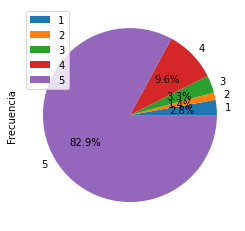

In [10]:
###ANALISIS UNIVARIADO
#Pie Chart, porcentajes de OverAll 
df_overall = df[['reviewerID', 'overall']]
pie_overall = df_overall.groupby('overall').agg('count')
pie_overall = pie_overall.rename(columns={'reviewerID': 'Frecuencia'})
pie_overall

axis = pie_overall.plot.pie(y='Frecuencia', autopct="%.1f%%", rot=0)
print(axis)
plt.show()


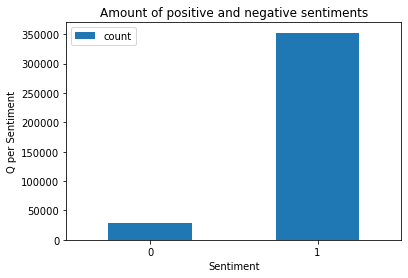

In [11]:
#Cantidad de sentimientos positivos y negativos
dfbp = pd.DataFrame({'count': df.groupby([ 'sentiment']).size()})
dfbp.head(5)

grafico = dfbp.plot.bar(y='count', rot=0)
plt.title("Amount of positive and negative sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Q per Sentiment")

plt.show()

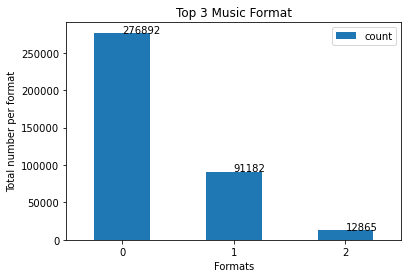

In [12]:
#Baplot para identificar el top 3 de Format 
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

dfformat = pd.DataFrame({'count': df.groupby(['style.Format:']).size()})
dflargest = dfformat.nlargest(3, 'count')

dflargest = dflargest.reset_index()

axis = dflargest.plot.bar(y='count', rot=0)
plt.title("Top 3 Music Format")
plt.xlabel("Formats")
plt.ylabel("Total number per format")
addlabels(dflargest['style.Format:'], dflargest['count'])
plt.show()

In [13]:
###ANALISIS BIVARIADO
##Recordar descomentar este apartado despues de agregar el filtro de fecha para que se puedan procesar bien los datos para el anállisis Bvariado
#prof = pandas_profiling.ProfileReport(df)
#prof

In [14]:
#### Agrupación sentiment vs overall para análisis númerico con categórico
df_s_o=df.groupby('sentiment')['overall'].mean()
###Creación de tabla para comparar dos variables categóricas (overall y sentiment)
df_s_o=pd.crosstab(df['overall'],df['sentiment'])
from scipy.stats import chi2_contingency
value=df_s_o.values
print(chi2_contingency(value)[0:3])
df_s_o
# Se confirma que la división de sentimiento positivo(1) negativo (0) fue hecha de manera correcta, ya que se ve una media para el sentimiento negativo de 1.76 y para un sentimiento positivo de 4.8
#Hay dependencia entre la variable de sentimiento y el overall

(380939.0, 0.0, 4)


sentiment,0,1
overall,,
1,10666,0
2,5211,0
3,12487,0
4,0,36723
5,0,315852


In [15]:
df_s_r=df.groupby('sentiment')['review_length'].mean()

df_s_r
#No existe ninguna relación significativa entre la cantidad de caracteres del comentario y el sentimiento generado 

sentiment
0    215.177831
1    121.263311
Name: review_length, dtype: float64

In [16]:
###Creación de tabla para comparar dos variables categóricas (style.Format: y sentiment)
df_s_s=pd.crosstab(df['style.Format:'],df['sentiment'])
from scipy.stats import chi2_contingency
value=df_s_s.values
print(chi2_contingency(value)[0:3])

(2460.6694605186512, 0.0, 2)


In [17]:
df_s_s

sentiment,0,1
style.Format:,,
Audio CD,9417,81765
MP3 Music,17178,259714
Vinyl,1769,11096


In [18]:
#Ho : si hay independencia entre sentimiento y el formato en el que viene la música
#Ha: si hay dependencia entre sentimiento y el formato en el que viene la música
#Como el P valor es menor al número de significancia entonces se rechaza la Ho, por lo cual si existe una dependencia entre el formato y el sentimiento, siento el top 3 el CD,MP3 y Vinyl.

In [19]:
###Creación de tabla para comparar dos variables categóricas (verified y sentiment)
df_v_s=pd.crosstab(df['verified'],df['sentiment'])
from scipy.stats import chi2_contingency
value=df_v_s.values
print(chi2_contingency(value)[0:3])
df_v_s

#Ho : si hay independencia entre sentimiento y el comentario verificado 
#Ha: si hay dependencia entre sentimiento y el comentario verificado 
#Como el P valor es menor al número de significancia entonces se rechaza la Ho, por lo cual si existe una dependencia entre el comentario verificado y el sentimiento


(2142.9518762678154, 0.0, 1)


sentiment,0,1
verified,,
False,6065,41950
True,22299,310625


In [20]:
df_s_v=df.groupby('overall')['vote'].mean()
df_s_v

#Los votos disminuyen a medida que el overall aumentan

overall
1    1.154228
2    0.700249
3    0.329543
4    0.168124
5    0.156576
Name: vote, dtype: float64

In [21]:
df

,overall,verified,reviewTime,reviewerID,reviewText,summary,style.Format:,vote,sentiment,review_length
146,5,True,2016-02-16,ASLU49IONJYFK,The best Christian music about the life of Chr...,Music to my soul.,MP3 Music,0,1,50
147,5,True,2016-01-05,A2Z5Q2YOVHFLLC,Beautiful!,Five Stars,Audio CD,0,1,10
248,5,True,2017-12-13,A2G68JR8JM3CVK,Great sounds and pace for massage or relaxation!,Five Stars,Audio CD,0,1,48
249,5,True,2017-10-30,A2REF5NAGDO02L,"Ethereal, and a VERY spiritual cd. I had no id...","Ethereal, and a VERY spiritual cd. I had ...",Audio CD,4,1,185
250,1,False,2017-10-10,A192BGYMUHWF9S,This is completely fake. I am an audio enginee...,This is fake - the melodies are created digita...,Audio CD,15,0,600
...,...,...,...,...,...,...,...,...,...,...
1584077,5,True,2018-03-03,AR3KABMPL5L0O,Casting Crowns....you do it so well! Awesome s...,Awesome song!,MP3 Music,0,1,50
1584078,4,True,2018-01-24,A2N53GHW73INDH,This band has produced many inspiring Christia...,This song in particular speaks about what it's...,MP3 Music,0,1,199
1584079,5,True,2017-04-21,ABNKLDCCVJKW1,Awesome band and awesome song. This is my next...,Five Stars,MP3 Music,0,1,70
1584080,5,True,2018-02-23,AMWSDABZWFRAT,Excellent,Five Stars,MP3 Music,0,1,9


In [22]:
#TRANSFORMACIÓN DE VARIABLES NOMINALES A NUMÉRICAS

df_numeric = df[['overall', 'vote', 'sentiment', 'review_length']]
df_categorical = df[['verified', 'style.Format:']]

In [23]:
df_categorical

,verified,style.Format:
146,True,MP3 Music
147,True,Audio CD
248,True,Audio CD
249,True,Audio CD
250,False,Audio CD
...,...,...
1584077,True,MP3 Music
1584078,True,MP3 Music
1584079,True,MP3 Music
1584080,True,MP3 Music


In [24]:
#Verificar cuales son los valores únicos para codificar
print(df['verified'].unique())
print(df['style.Format:'].unique())

[ True False]
[' MP3 Music' ' Audio CD' ' Vinyl']


In [25]:
#Codificar verified
from sklearn.preprocessing import LabelEncoder

verified_encoder = LabelEncoder()
verified_encoder.fit(df_categorical['verified'])
verified_values = verified_encoder.transform(df_categorical['verified'])

In [26]:
#Codificar style.Format: 
from sklearn.preprocessing import OneHotEncoder

format_encoder = OneHotEncoder()
format_reshaped = np.array(df_categorical['style.Format:']).reshape(-1, 1)
format_values = format_encoder.fit_transform(format_reshaped)

In [27]:
verified = pd.DataFrame(verified_values, columns=['verified'])
format = pd.DataFrame(format_values.toarray(), columns=[' Audio CD', ' MP3 Music', ' Vinyl'])
df_categorical_encoded = pd.concat([verified, format], axis=1)

In [28]:
df_categorical_encoded.index = range(df_categorical_encoded.shape[0])
df_numeric.index = range(df_numeric.shape[0])

In [29]:
df_new = pd.concat([df_numeric, df_categorical_encoded], axis=1)

In [30]:
#Revisar cantidad de nulos
df_new.isna().sum()

overall          0
vote             0
sentiment        0
review_length    0
verified         0
 Audio CD        0
 MP3 Music       0
 Vinyl           0
dtype: int64

In [31]:
#X_test

In [33]:
###ALGORITMO DE CLASIFICACION
###Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [34]:
#Separamos en X e y
X = df_new.drop(["sentiment", "overall", " Audio CD", " MP3 Music", " Vinyl"], axis=1)
y = df_new["sentiment"]

In [35]:
X

,vote,review_length,verified
0,0,50,1
1,0,10,1
2,0,48,1
3,4,185,1
4,15,600,0
...,...,...,...
380934,0,50,1
380935,0,199,1
380936,0,70,1
380937,0,9,1


In [36]:
df_new.sentiment.value_counts()

1    352575
0     28364
Name: sentiment, dtype: int64

In [37]:
(X_train, X_test,y_train, y_test) = train_test_split(X,y,stratify=y,test_size=0.30,random_state=42)

In [38]:
#Creamos un arbol de decisión sencillo y lo fiteamos
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [39]:
y_test_pred = tree.predict(X_test) #Prediccion en Test
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [41]:
from sklearn.metrics import accuracy_score

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de evaluación: 0.9259113421186188


In [42]:
#Matriz de Confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)
#Explicación: Existen tan solo 37 predicciones acertadas de los comentarios positivos. De los valores negativos, existen 362636 predicciones correctas.
#Lo preocupante está en que hay 30040 falsos negativos, lo que quiere decir que le estamos atribuyendo a esa cantidad una valencia negativa, cuando realmente podría ser positiva.
#Finalmente, solo hay 43 falsos negativos. Con esta distribucción de la matriz podemos ver lo sesgada que está nuestra muestra al tener tantos valores positivos.

array([[    90,   8419],
       [    48, 105725]], dtype=int64)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.01      0.02      8509
           1       0.93      1.00      0.96    105773

    accuracy                           0.93    114282
   macro avg       0.79      0.51      0.49    114282
weighted avg       0.91      0.93      0.89    114282



In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

LABELS= ['Normal','Fraudulent']

In [45]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

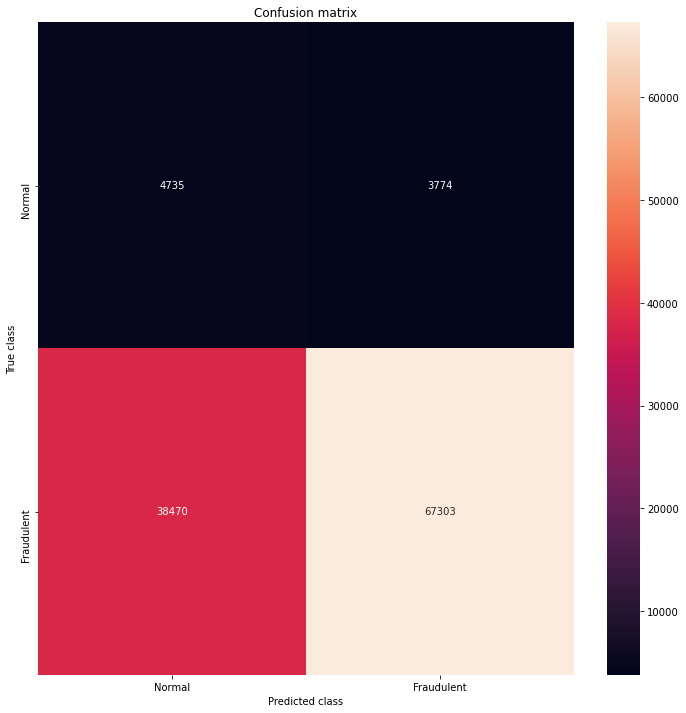

              precision    recall  f1-score   support

           0       0.11      0.56      0.18      8509
           1       0.95      0.64      0.76    105773

    accuracy                           0.63    114282
   macro avg       0.53      0.60      0.47    114282
weighted avg       0.88      0.63      0.72    114282



In [46]:
#Esamble de Modelos con Balanceo
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

#Train the classifier.
bbc.fit(X_train, y_train)
pred_y = bbc.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [47]:
#######################################SMOTE##############################
!pip install imbalanced-learn

In [48]:
from imblearn.over_sampling import SMOTE
sm= SMOTE (random_state=42)
X_sm,y_sm= sm.fit_resample(X,y)

print(f'''Cambiode X antes de SMOTE: {X.shape}
Cambio de X despues SMOTE {X_sm.shape}''')

print ('\nBalance position and negativo de la clase (%):')
y_sm.value_counts(normalize=True)*100

Cambiode X antes de SMOTE: (380939, 3)
Cambio de X despues SMOTE (705150, 3)

Balance position and negativo de la clase (%):


0    50.0
1    50.0
Name: sentiment, dtype: float64

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


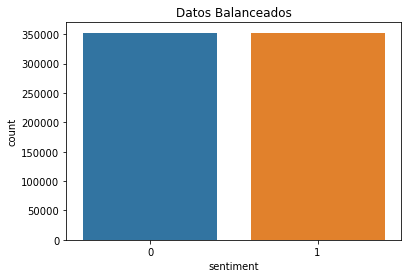

In [49]:
sns.countplot(y_sm);
plt.title("Datos Balanceados");

In [50]:
###ANÁLISIS MULTIVARIADO

#Predicción del sentimiento o overall según verified ,vote, styleformat y reviewTime

##SVM

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_new[['vote','review_length','verified']].values,
                                                    df_new.sentiment, test_size=0.3,random_state=42) # 70% training and 30% test



In [ ]:
###############EJECUCIÓN MODELO SVM##############3
from sklearn import svm
#Svm Classifier
clf = svm.SVC(kernel='rbf',C=0.1) # Kernel Lineal (Existen diversos tipos de kernel linear, rbf, poly,sigmoid )
#Entrenar el modelo
clf.fit(X_sm, y_sm)
#Obtener las predicciones
y_pred = clf.predict(X_sm)
y_pred

#X_sm,y_sm

##############EL MODELO NO DEJA DE EJECUTARSE PERO TAMPOCO PRESENTA ERRORES

In [53]:
from sklearn import metrics
#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) # Se tiene un accuracy del 83%

Accuracy: 0.9255088290369436


In [ ]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(X_train, y_train)